In [1]:
import numpy as np
#import matplotlib.pyplot as plt
#import matplotlib
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col
from statsmodels.stats.anova import anova_lm
#%matplotlib inline

#from useful_functions.plotter import plot

#idx = pd.IndexSlice

In [2]:
sns.set_style("ticks")
sns.set_context("paper",font_scale=2.0)
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})

import matplotlib
import matplotlib.pyplot as plt
font = {'family': 'serif', 'serif': ['Gentium Basic'], 'size': 10}
plt.rc('font', **font)
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Gentium Basic'
matplotlib.rcParams['mathtext.it'] = 'Gentium Basic:italic'
matplotlib.rcParams['mathtext.bf'] = 'Gentium Basic:bold'

from matplotlib.backends.backend_pgf import FigureCanvasPgf
matplotlib.backend_bases.register_backend('pdf', FigureCanvasPgf)

pgf_with_custom_preamble = {
"font.family": "serif", # use serif/main font for text elements
"text.usetex": False,    # use inline math for ticks
"pgf.preamble": [
    "\\usepackage{mathpazo}",
    "\\usepackage{gentium}",
    "\\DeclareSymbolFont{sfnumbers}{T1}{gentium}{m}{n}",
    "\\SetSymbolFont{sfnumbers}{bold}{T1}{gentium}{bx}{n}",
    "\\DeclareMathSymbol{0}\mathalpha{sfnumbers}{\"30}",
    "\\DeclareMathSymbol{1}\mathalpha{sfnumbers}{\"31}",
    "\\DeclareMathSymbol{2}\mathalpha{sfnumbers}{\"32}",
    "\\DeclareMathSymbol{3}\mathalpha{sfnumbers}{\"33}",
    "\\DeclareMathSymbol{4}\mathalpha{sfnumbers}{\"34}",
    "\\DeclareMathSymbol{5}\mathalpha{sfnumbers}{\"35}",
    "\\DeclareMathSymbol{6}\mathalpha{sfnumbers}{\"36}",
    "\\DeclareMathSymbol{7}\mathalpha{sfnumbers}{\"37}",
    "\\DeclareMathSymbol{8}\mathalpha{sfnumbers}{\"38}",
    "\\DeclareMathSymbol{9}\mathalpha{sfnumbers}{\"39}",
    "\\DeclareMathSymbol{,}\mathalpha{sfnumbers}{\"2C}"
    ]
}
matplotlib.rcParams.update(pgf_with_custom_preamble)


In [3]:
data = pd.read_csv('final_eu_data.csv')

north_subset = ['Sweden', 'Denmark', 'Estonia', 'Latvia', 'Lithuania']
east_subset = ['Czech Republic', 'Austria', 'Croatia', 'Hungary', 'Poland', 'Romania', 'Slovakia', 'Slovenia', 'Bulgaria']
south_subset = ['Italy', 'Spain', 'Portugal', 'Greece']

data['eu_region'] = 'western'
data.loc[data['country'].isin(east_subset), 'eu_region'] = 'eastern'
data.loc[data['country'].isin(south_subset), 'eu_region'] = 'southern'
data.loc[data['country'].isin(north_subset), 'eu_region'] = 'northern'

data = data.reset_index(drop=True).set_index(['country','week'])

countries = ["Austria", "Belgium", "Bulgaria", "Denmark", "France", "Germany",
             "Greece", "Hungary", "Ireland", "Italy", "Latvia", "Lithuania", "Luxembourg", "Netherlands",
             "Poland", "Portugal", "Romania", "Slovakia", "Slovenia", "Spain", "Sweden", "United Kingdom"]

data['case_weekly_count_pc'] = data['case_weekly_count'] / data['population']
data['death_weekly_count_pc'] = data['death_weekly_count'] / data['population']

In [4]:
# The quantity stored in week N corresponds to the total pc cases over weeks N-2, N-1, and N

# We will use the same convention for all measures: new cases/deaths from week in are included in week N's row
# so there is NO lag currently between these quantities and the SDI/containment

# Now, for week N, this tells us the containment/sdi at week N-1
data['containment_lag1wk'] = data['ContainmentHealthIndex'].groupby('country').shift(1)
data['sdi_lag1wk'] = data['sdi'].groupby('country').shift(1)

data['case_biweekly_count_pc'] = data['case_weekly_count_pc'].groupby('country').rolling(2).sum().droplevel(level=0)
data['case_triweekly_count_pc'] = data['case_weekly_count_pc'].groupby('country').rolling(3).sum().droplevel(level=0)
data['case_quadweekly_count_pc'] = data['case_weekly_count_pc'].groupby('country').rolling(4).sum().droplevel(level=0)

data['case_weekly_count_pc_lag1wk'] = data['case_weekly_count_pc'].groupby('country').shift(1)
data['case_biweekly_count_pc_lag1wk'] = data['case_biweekly_count_pc'].groupby('country').shift(1)
data['case_triweekly_count_pc_lag1wk'] = data['case_triweekly_count_pc'].groupby('country').shift(1)
data['case_quadweekly_count_pc_lag1wk'] = data['case_quadweekly_count_pc'].groupby('country').shift(1)

data['case_weekly_wow_growth']  = data['case_weekly_count'] / data['case_weekly_count'].groupby('country').shift(1)
data['death_weekly_wow_growth'] = data['death_weekly_count'] / data['death_weekly_count'].groupby('country').shift(1)

data['case_weekly_wow_growth_lead1wk'] = data['case_weekly_wow_growth'].groupby('country').shift(-1)
data['death_weekly_wow_growth_lead1wk'] = data['death_weekly_wow_growth'].groupby('country').shift(-1)
data['death_weekly_wow_growth_lead2wk'] = data['death_weekly_wow_growth'].groupby('country').shift(-2)
data['death_weekly_wow_growth_lead3wk'] = data['death_weekly_wow_growth'].groupby('country').shift(-3)

# week N cases / (sum week N-4, N-3, N-2, N-1 cases)
data['infectivity'] = data['case_weekly_count_pc'] / data['case_quadweekly_count_pc'].groupby('country').shift(1)
data['infectivity_next_week'] = data['infectivity'].groupby('country').shift(-1)

data = data.replace([np.inf, -np.inf], np.nan)


In [4]:
data

ContainmentHealthIndex  population  case_weekly_count  \
country        week                                                          
Austria        9                  14.100000   8858775.0               14.0   
               10                 15.748571   8858775.0               88.0   
               11                 43.221429   8858775.0              758.0   
               12                 63.551429   8858775.0             2771.0   
               13                 66.480000   8858775.0             5182.0   
...                                     ...         ...                ...   
United Kingdom 47                 60.991429  66647112.0           142727.0   
               48                 61.540000  66647112.0           105282.0   
               49                 58.717143  66647112.0           105915.0   
               50                 65.330000  66647112.0           126161.0   
               51                 69.542857  66647112.0           190744.0   

                     case_rate_14_day  case_cumulative_count  \
country        week                                            
Austria        9             0.158035                   14.0   
               10            1.151401                  102.0   
               11            9.549853                  860.0   
               12           39.836208                 3631.0   
               13           89.775392                 8813.0   
...                               ...                    ...   
United Kingdom 47          480.188849              1512045.0   
               48          372.122651              1617327.0   
               49          316.888450              1723242.0   
               50          348.216139              1849403.0   
               51          475.496973              2040147.0   

                     death_weekly_count  death_rate_14_day  \
country        week                                          
Austria        9                    0.0           0.000000   
               10                   0.0           0.000000   
               11                   1.0           0.112882   
               12                  15.0           1.806119   
               13                  70.0           9.595006   
...                                 ...                ...   
United Kingdom 47                2817.0          85.630117   
               48                3494.0          94.692775   
               49                3000.0          97.438581   
               50                2925.0          88.901076   
               51                3231.0          92.367093   

                     death_cumulative_count        sdi eu_region  ...  \
country        week                                               ...   
Austria        9                        0.0   1.722814   eastern  ...   
               10                       0.0   4.309652   eastern  ...   
               11                       1.0  15.872029   eastern  ...   
               12                      16.0  71.152199   eastern  ...   
               13                      86.0  83.867208   eastern  ...   
...                                     ...        ...       ...  ...   
United Kingdom 47                   54751.0  54.536141   western  ...   
               48                   58245.0  52.946549   western  ...   
               49                   61245.0  45.969583   western  ...   
               50                   64170.0  40.823736   western  ...   
               51                   67401.0  40.942887   western  ...   

                     case_triweekly_count_pc_lag1wk  \
country        week                                   
Austria        9                                NaN   
               10                               NaN   
               11                               NaN   
               12                          0.000097   
               13                          0.000408   
...                            

In [141]:

data

ContainmentHealthIndex  population  case_weekly_count  \
country        week                                                          
Austria        9                  14.100000   8858775.0               14.0   
               10                 15.748571   8858775.0               88.0   
               11                 43.221429   8858775.0              758.0   
               12                 63.551429   8858775.0             2771.0   
               13                 66.480000   8858775.0             5182.0   
...                                     ...         ...                ...   
United Kingdom 47                 60.991429  66647112.0           142727.0   
               48                 61.540000  66647112.0           105282.0   
               49                 58.717143  66647112.0           105915.0   
               50                 65.330000  66647112.0           126161.0   
               51                 69.542857  66647112.0           190744.0   

                     case_rate_14_day  case_cumulative_count  \
country        week                                            
Austria        9             0.158035                   14.0   
               10            1.151401                  102.0   
               11            9.549853                  860.0   
               12           39.836208                 3631.0   
               13           89.775392                 8813.0   
...                               ...                    ...   
United Kingdom 47          480.188849              1512045.0   
               48          372.122651              1617327.0   
               49          316.888450              1723242.0   
               50          348.216139              1849403.0   
               51          475.496973              2040147.0   

                     death_weekly_count  death_rate_14_day  \
country        week                                          
Austria        9                    0.0           0.000000   
               10                   0.0           0.000000   
               11                   1.0           0.112882   
               12                  15.0           1.806119   
               13                  70.0           9.595006   
...                                 ...                ...   
United Kingdom 47                2817.0          85.630117   
               48                3494.0          94.692775   
               49                3000.0          97.438581   
               50                2925.0          88.901076   
               51                3231.0          92.367093   

                     death_cumulative_count        sdi eu_region  ...  \
country        week                                               ...   
Austria        9                        0.0   1.722814   eastern  ...   
               10                       0.0   4.309652   eastern  ...   
               11                       1.0  15.872029   eastern  ...   
               12                      16.0  71.152199   eastern  ...   
               13                      86.0  83.867208   eastern  ...   
...                                     ...        ...       ...  ...   
United Kingdom 47                   54751.0  54.536141   western  ...   
               48                   58245.0  52.946549   western  ...   
               49                   61245.0  45.969583   western  ...   
               50                   64170.0  40.823736   western  ...   
               51                   67401.0  40.942887   western  ...   

                     case_triweekly_count_pc_lag1wk  \
country        week                                   
Austria        9                                NaN   
               10                               NaN   
               11                               NaN   
               12                          0.000097   
               13                          0.000408   
...                            

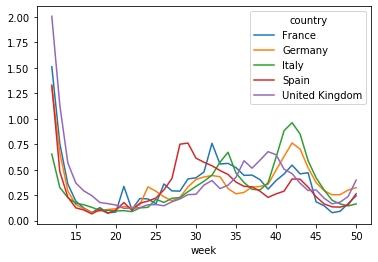

In [57]:
data.loc[data['country'].isin(region_subset)].groupby(['week', 'country'])['infectivity_next_week'].mean().unstack().plot(ax=plt.gca())


Text(0, 0.5, 'Number of EU countries')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Gentium Basic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Gentium Basic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Gentium Basic'] not found. Falling back to DejaVu Sans.


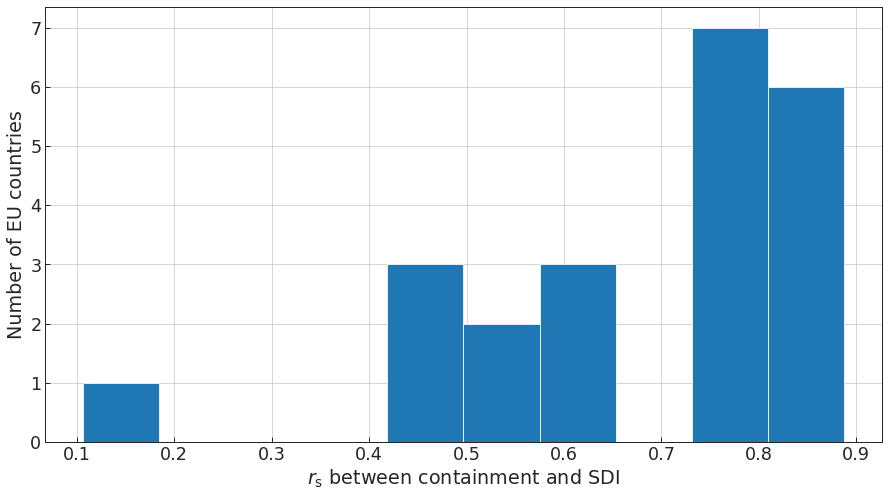

In [6]:
# Correlation between containment index and SDI

fig,ax=plt.subplots(1,figsize=(15,8))
data.loc[:,['ContainmentHealthIndex', 'sdi']].groupby('country').corr('spearman').unstack()['ContainmentHealthIndex']['sdi'].hist()
ax.set_xlabel(r'$r_{\rm s}$ between containment and SDI')
ax.set_ylabel(r'Number of EU countries')

# SDI and containment are not correlated at all for UK

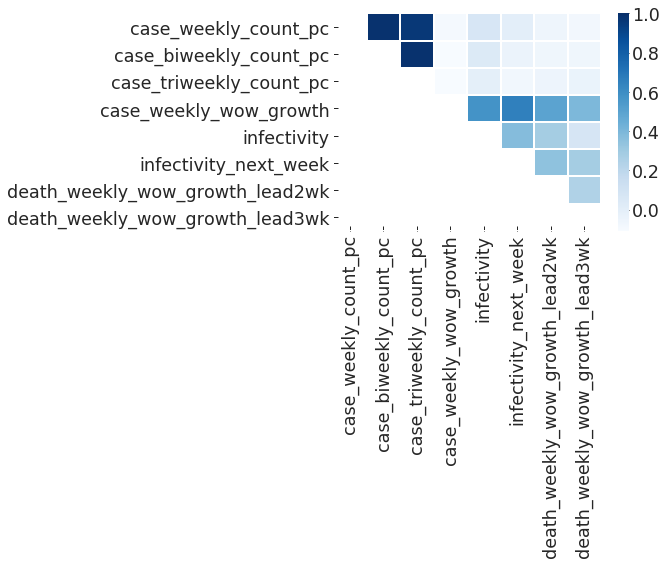

In [7]:
matplotlib.rcParams['text.usetex'] = False

outcome_vars = ['case_weekly_count_pc', 'case_biweekly_count_pc', 'case_triweekly_count_pc', 'case_weekly_wow_growth',
               'infectivity', 'infectivity_next_week', 'death_weekly_wow_growth_lead2wk', 'death_weekly_wow_growth_lead3wk']

sns.heatmap(data[outcome_vars].corr(), mask=np.tril(np.ones((len(outcome_vars), len(outcome_vars)))).astype(np.bool), 
            linewidth=1, linecolor='white', cmap='Blues')

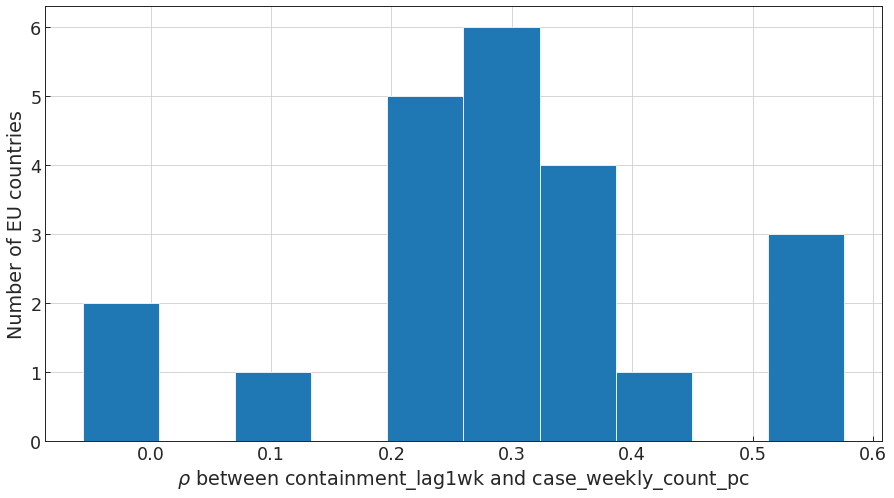

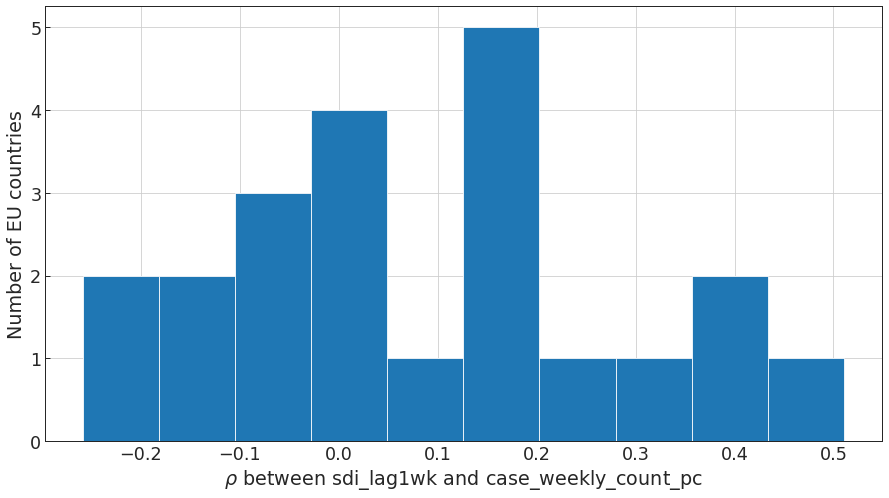

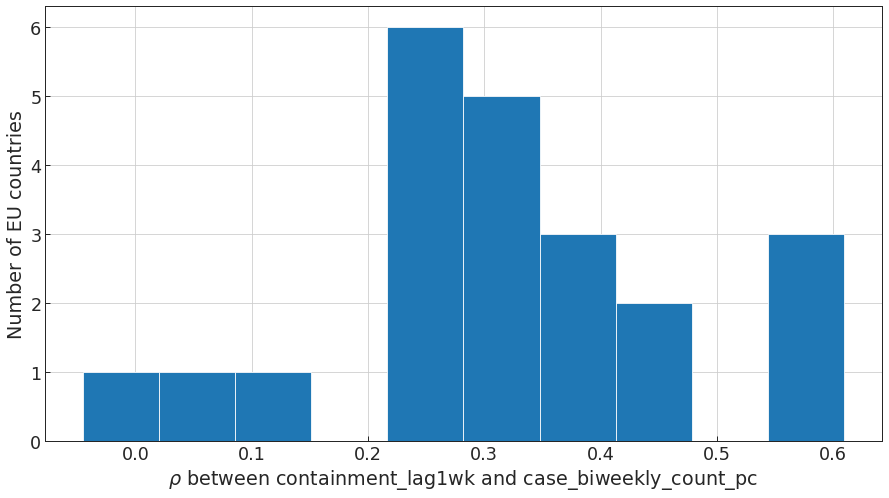

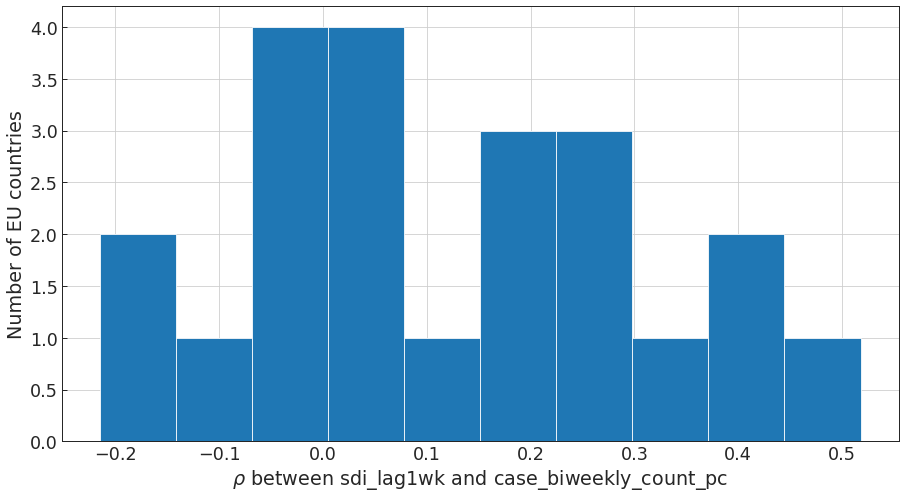

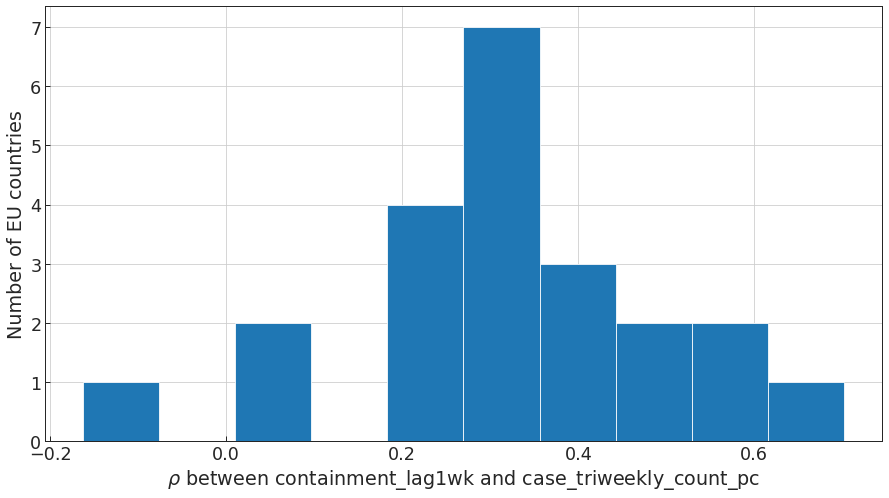

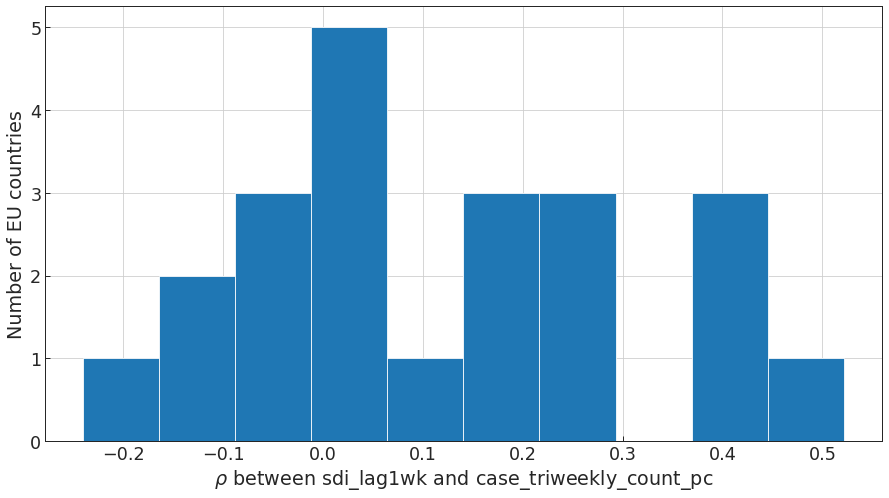

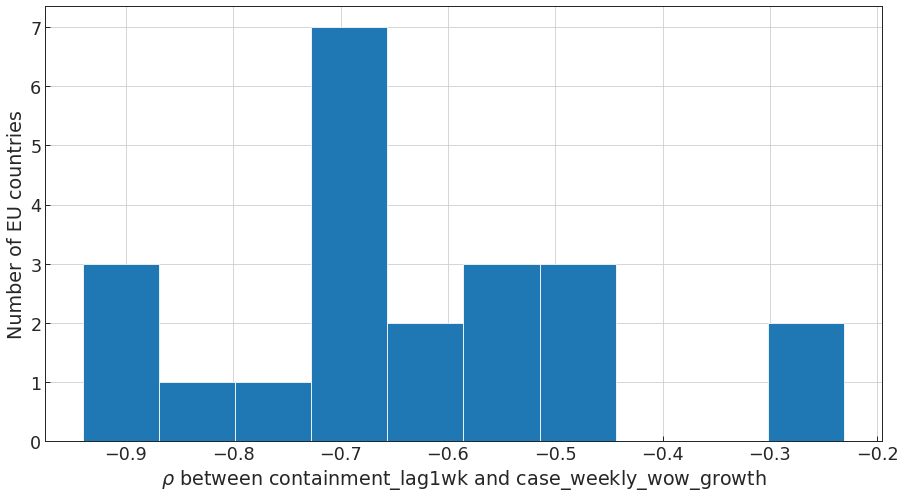

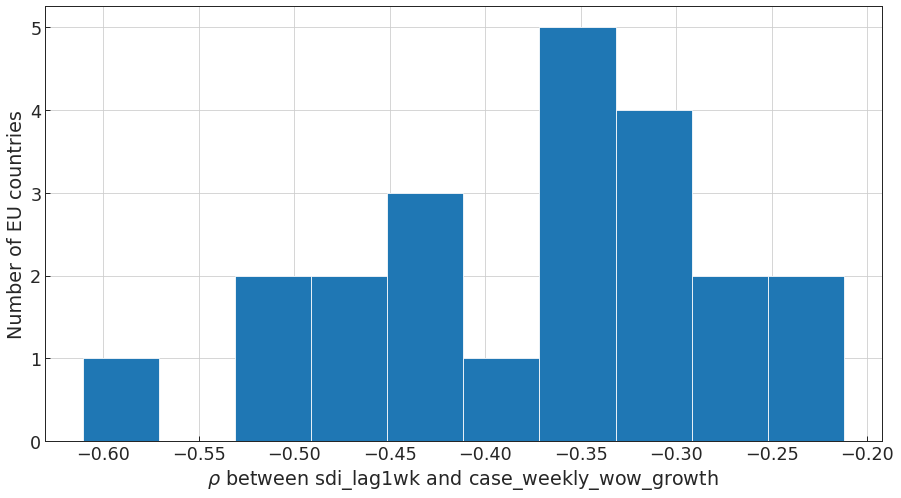

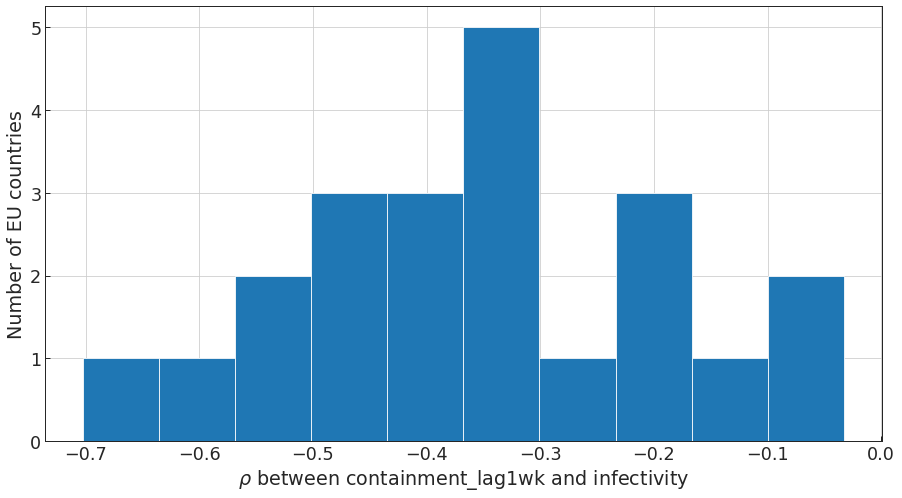

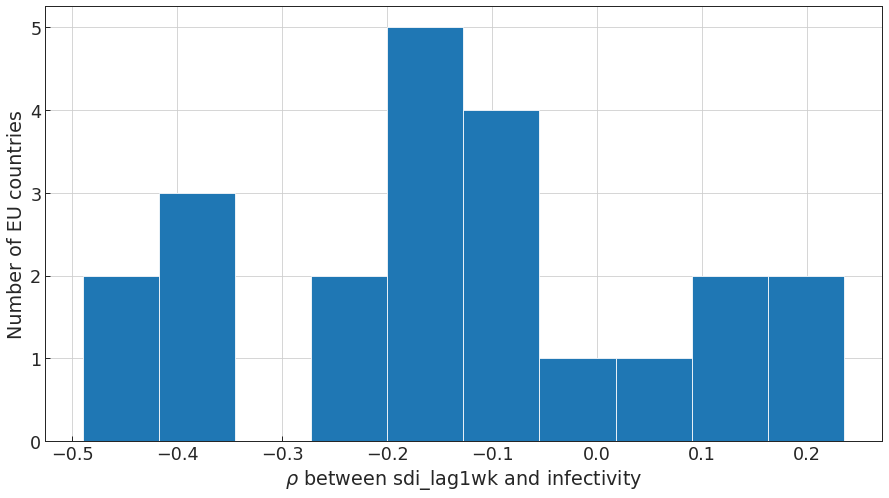

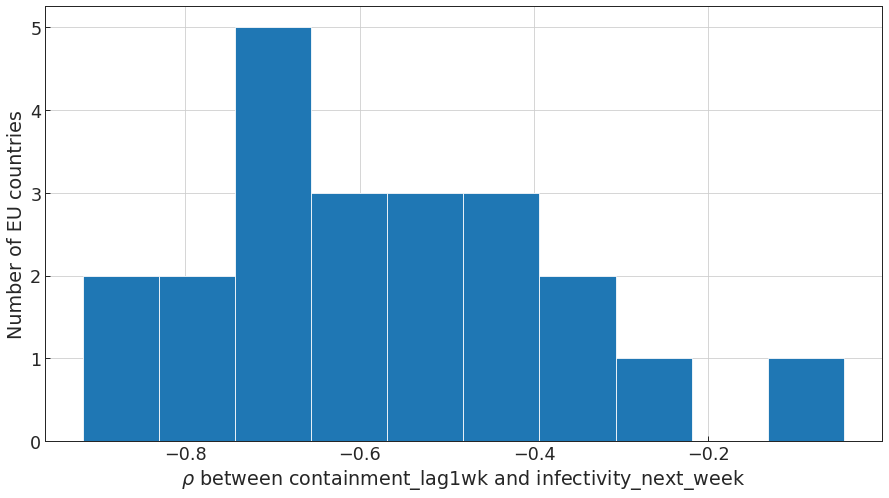

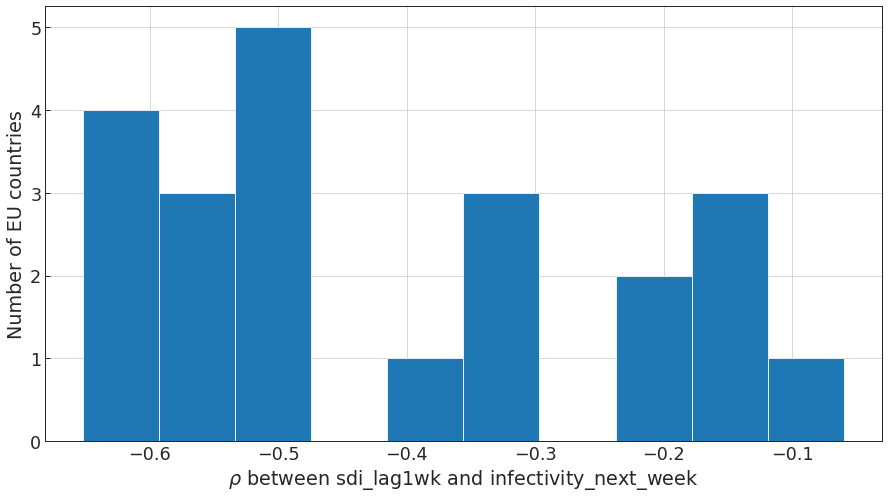

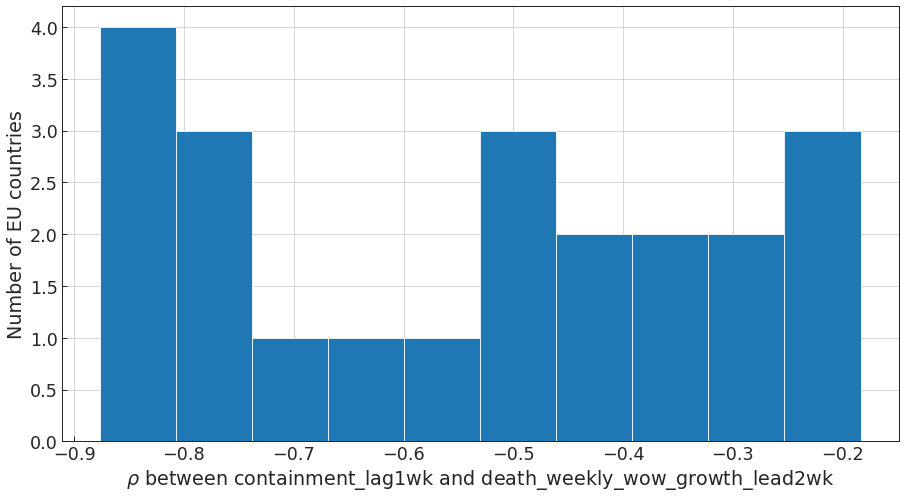

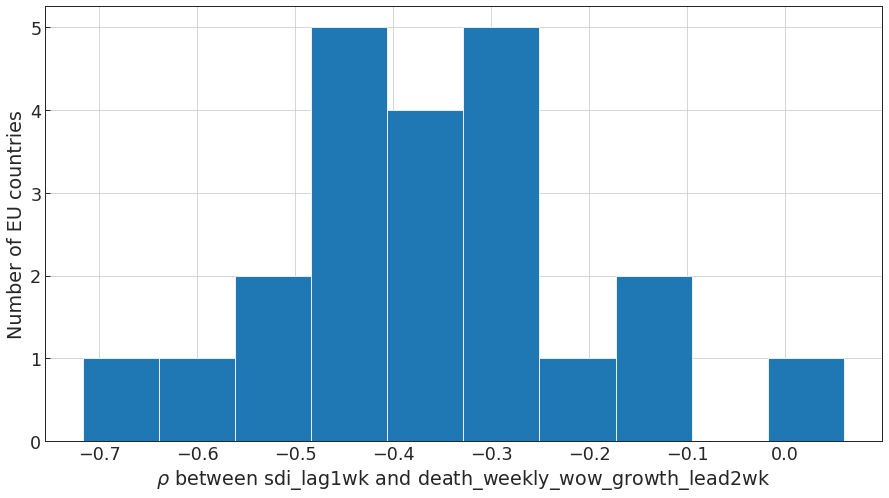

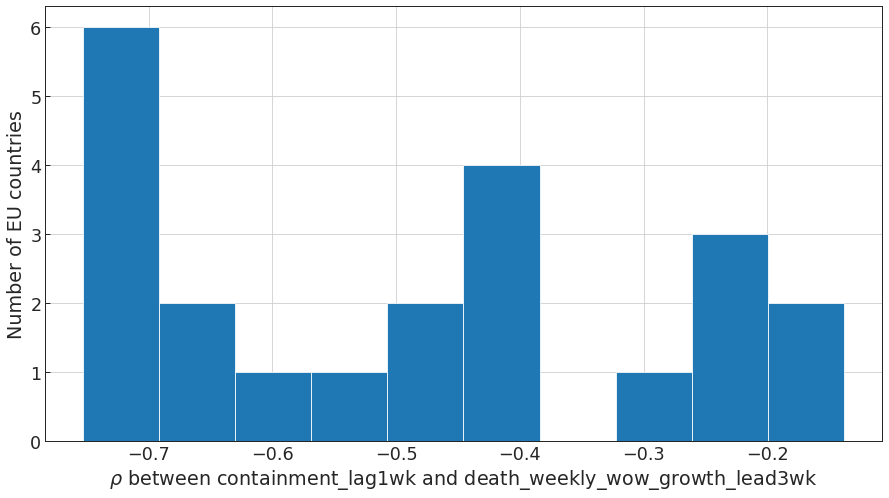

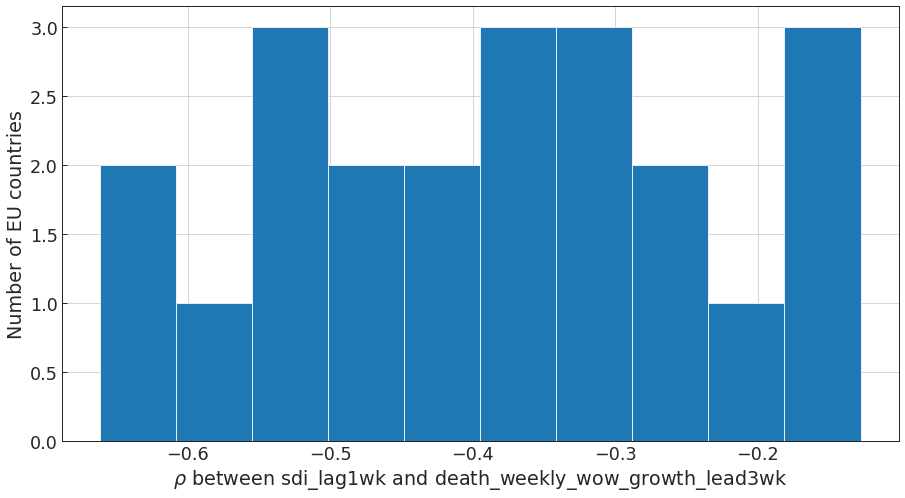

In [8]:
# On a country-by-country basis, how well do these measures of spread/case growth correlate with SDI/containment

ind_vars = ['containment_lag1wk', 'sdi_lag1wk']

for out in outcome_vars:
    for ind in ind_vars:
        fig, ax = plt.subplots(1,figsize=(15,8))
        matplotlib.rcParams['text.usetex'] = False
        data.loc[:,[ind, out]].groupby('country').corr().unstack()[ind][out].hist()
        plt.xlabel(r'$\rho$ between %s and %s' % (ind, out))
        plt.ylabel(r'Number of EU countries')

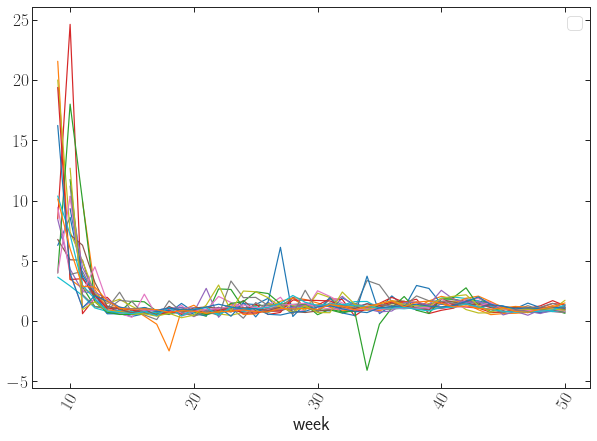

In [129]:
fig, ax = plot(figsize=(10,7))

for i,c in enumerate(countries):
    data.loc[idx[c]].plot(y='case_weekly_wow_growth_lead1wk', ax=ax)
    
plt.xticks(rotation = 60)
plt.legend([],[])

# Find the countries with negative growth/infectivity

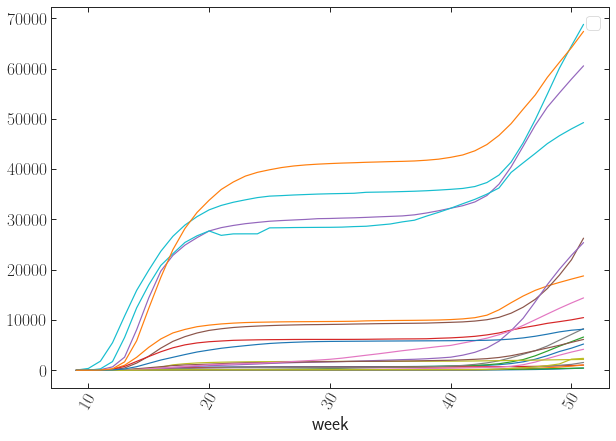

In [126]:
fig, ax = plot(figsize=(10,7))

for i,c in enumerate(countries):
    data.loc[idx[c]].plot(y='death_cumulative_count', ax=ax)
    
plt.xticks(rotation = 60)
plt.legend([],[])

In [5]:
# [RESULTS TO USE]



# Relating containment/sdi that come from week N-1 with death_wow_2wklead that comes from week N+1 and N+2 might be
# a bit silly, should probably instead consider 1wk lead deaths, from week N and N+1

data['quarter'] = (data.index.get_level_values('week') // 13).astype(str) # Not sure if str type will matter
print(data['quarter'].value_counts())


data['month'] = (data.index.get_level_values('week') // 4).astype(str) # Not sure if str type will matter
print(data['month'].value_counts())


# There's a lot less of the first quarter, but let's just see how it performs

# NOTE: All indicator variables are evaluated up to week N-1
# For example, containment/sdi are averaged over week N-1
# Biweekly case count pc is the summed cases from week N-2 and N-1, etc.

# outcome variables are evaluated through week N unless otherwise specified, some of which lead by 1 or 2 weeks (and hence evaluated at week N+1 or N+2)

all_res = []
ind_vars = ['containment_lag1wk', 'sdi_lag1wk', 'case_biweekly_count_pc_lag1wk', 'case_triweekly_count_pc_lag1wk', 'case_quadweekly_count_pc_lag1wk']
outcome_vars = ['infectivity', 'case_weekly_wow_growth', 'infectivity_next_week', 'case_weekly_wow_growth', 'case_weekly_wow_growth_lead1wk', 'death_weekly_wow_growth', 'death_weekly_wow_growth_lead1wk', 'death_weekly_wow_growth_lead2wk']

for outcome in outcome_vars:
    all_res = []
    regress_dat = data.loc[~pd.isna(data[[outcome] + ind_vars]).any(axis=1)].reset_index()
    print(regress_dat.shape)
    #all_res.append(smf.ols(formula=outcome + ' ~ C(country) ', data=regress_dat).fit(cov_type='cluster',cov_kwds={'groups':regress_dat['country']}))
    all_res.append(smf.ols(formula=outcome + ' ~ C(eu_region) + C(month) + containment_lag1wk', data=regress_dat).fit(cov_type='cluster',cov_kwds={'groups':regress_dat['country']}))
    all_res.append(smf.ols(formula=outcome + ' ~ C(eu_region) + C(month) + sdi_lag1wk', data=regress_dat).fit(cov_type='cluster',cov_kwds={'groups':regress_dat['country']}))
    all_res.append(smf.ols(formula=outcome + ' ~ C(eu_region) + C(month) + containment_lag1wk + sdi_lag1wk', data=regress_dat).fit(cov_type='cluster',cov_kwds={'groups':regress_dat['country']}))
    
    #all_res.append(smf.ols(formula=outcome + ' ~ C(eu_region) + C(month) + containment_lag1wk + sdi_lag1wk + case_biweekly_count_pc_lag1wk + case_triweekly_count_pc_lag1wk + case_quadweekly_count_pc_lag1wk', data=regress_dat).fit(cov_type='cluster',cov_kwds={'groups':regress_dat['country']}))
    
    #all_res.append(smf.ols(formula=outcome + ' ~ C(month) + containment_lag1wk', data=regress_dat).fit(cov_type='cluster',cov_kwds={'groups':regress_dat['country']}))
    #all_res.append(smf.ols(formula=outcome + ' ~ C(month) + sdi_lag1wk', data=regress_dat).fit(cov_type='cluster',cov_kwds={'groups':regress_dat['country']}))
    #all_res.append(smf.ols(formula=outcome + ' ~ C(month) + containment_lag1wk + sdi_lag1wk', data=regress_dat).fit(cov_type='cluster',cov_kwds={'groups':regress_dat['country']}))
    
    #all_res.append(smf.ols(formula=outcome + ' ~ C(month) + containment_lag1wk + sdi_lag1wk + case_biweekly_count_pc_lag1wk + case_triweekly_count_pc_lag1wk + case_quadweekly_count_pc_lag1wk', data=regress_dat).fit(cov_type='cluster',cov_kwds={'groups':regress_dat['country']}))
    base = all_res[0]
    print(summary_col(all_res, regressor_order=['containment_lag1wk', 'sdi_lag1wk'], 
                     drop_omitted=True, stars=True, 
                     info_dict={'N': lambda x:(x.nobs), 'R2':lambda x:(x.rsquared), 'Adj.R2':lambda x:(x.rsquared_adj)}))
    #                                 'F':lambda x:(anova_lm(base, x).iloc[1]['F']

3    286
2    286
1    286
0     88
Name: quarter, dtype: int64
10    88
7     88
11    88
3     88
12    88
6     88
5     88
8     88
4     88
9     88
2     66
Name: month, dtype: int64
(858, 33)

                   infectivity I infectivity II infectivity III
---------------------------------------------------------------
containment_lag1wk -0.0095***                   -0.0055***     
                   (0.0014)                     (0.0016)       
sdi_lag1wk                       -0.0079***     -0.0065***     
                                 (0.0017)       (0.0019)       
N                  858.0000      858.0000       858.0000       
R2                 0.2384        0.2545         0.2617         
Adj.R2             0.2266        0.2430         0.2494         
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01
(858, 33)

                   case_weekly_wow_growth I case_weekly_wow_growth II case_weekly_wow_growth III
---------------------------------------------------------

In [ ]:
# to do: regression
# then: move on to EDA and plot production
# can plot death/case trajectories as well

In [64]:
data

ContainmentHealthIndex  population  case_weekly_count  \
country        week                                                          
Austria        9                  14.100000   8858775.0               14.0   
               10                 15.748571   8858775.0               88.0   
               11                 43.221429   8858775.0              758.0   
               12                 63.551429   8858775.0             2771.0   
               13                 66.480000   8858775.0             5182.0   
...                                     ...         ...                ...   
United Kingdom 47                 60.991429  66647112.0           142727.0   
               48                 61.540000  66647112.0           105282.0   
               49                 58.717143  66647112.0           105915.0   
               50                 65.330000  66647112.0           126161.0   
               51                 69.542857  66647112.0           190744.0   

                     case_rate_14_day  case_cumulative_count  \
country        week                                            
Austria        9             0.158035                   14.0   
               10            1.151401                  102.0   
               11            9.549853                  860.0   
               12           39.836208                 3631.0   
               13           89.775392                 8813.0   
...                               ...                    ...   
United Kingdom 47          480.188849              1512045.0   
               48          372.122651              1617327.0   
               49          316.888450              1723242.0   
               50          348.216139              1849403.0   
               51          475.496973              2040147.0   

                     death_weekly_count  death_rate_14_day  \
country        week                                          
Austria        9                    0.0           0.000000   
               10                   0.0           0.000000   
               11                   1.0           0.112882   
               12                  15.0           1.806119   
               13                  70.0           9.595006   
...                                 ...                ...   
United Kingdom 47                2817.0          85.630117   
               48                3494.0          94.692775   
               49                3000.0          97.438581   
               50                2925.0          88.901076   
               51                3231.0          92.367093   

                     death_cumulative_count        sdi  case_weekly_count_pc  \
country        week                                                            
Austria        9                        0.0  40.066431              0.000002   
               10                       0.0  43.010222              0.000010   
               11                       1.0  54.770036              0.000086   
               12                      16.0  84.912066              0.000313   
               13                      86.0  90.277739              0.000585   
...                                     ...        ...                   ...   
United Kingdom 47                   54751.0  67.466447              0.002142   
               48                   58245.0  66.386354              0.001580   
               49                   61245.0  62.005753              0.001589   
               50                   64170.0  58.534482              0.001893   
               51                   67401.0  59.337215              0.002862   

                     ...  case_biweekly_count_pc  case_triweekly_count_pc  \
country        week  ...                                                    
Austria        9     ...                     NaN                      NaN   
               10    ...                0.000012                      NaN   
               11

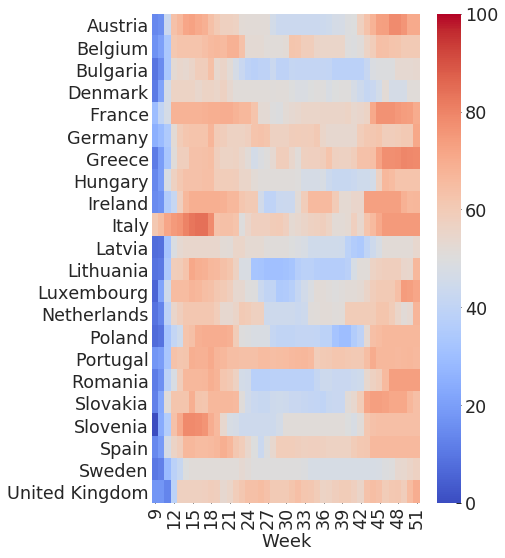

<Figure size 432x288 with 0 Axes>

In [23]:
# [RESULTS TO USE]

fig,ax = plt.subplots(figsize=(6, 9))
sns.heatmap(data.groupby(['country', 'week'])['ContainmentHealthIndex'].mean().unstack(), 
            vmin=0, vmax=100, cmap='coolwarm', ax=ax)
ax.set_xlabel(r'Week', fontsize=18)
ax.set_ylabel(r'', fontsize=18)
plt.show()
plt.savefig('heatmap1.eps', bbox_inches='tight')


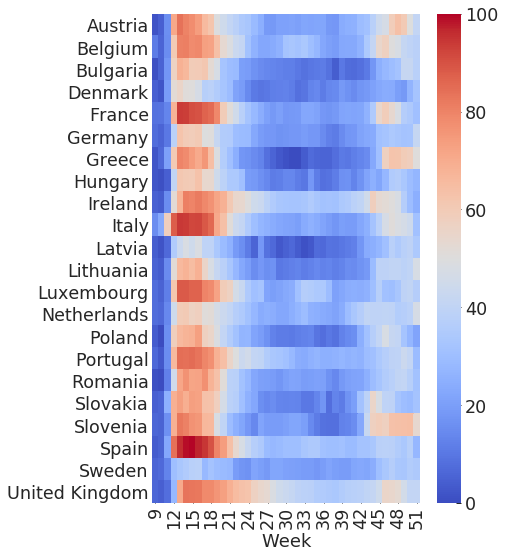

<Figure size 432x288 with 0 Axes>

In [24]:
# [RESULTS TO USE]

fig,ax = plt.subplots(figsize=(6, 9))
sns.heatmap(data.groupby(['country', 'week'])['sdi'].mean().unstack(), 
            vmin=0, vmax=100, cmap='coolwarm', ax=ax)

ax.set_xlabel(r'Week', fontsize=18)
ax.set_ylabel(r'', fontsize=18)
plt.show()
plt.savefig('heatmap2.eps', bbox_inches='tight')


Text(0, 0.5, 'Social Distancing Index')

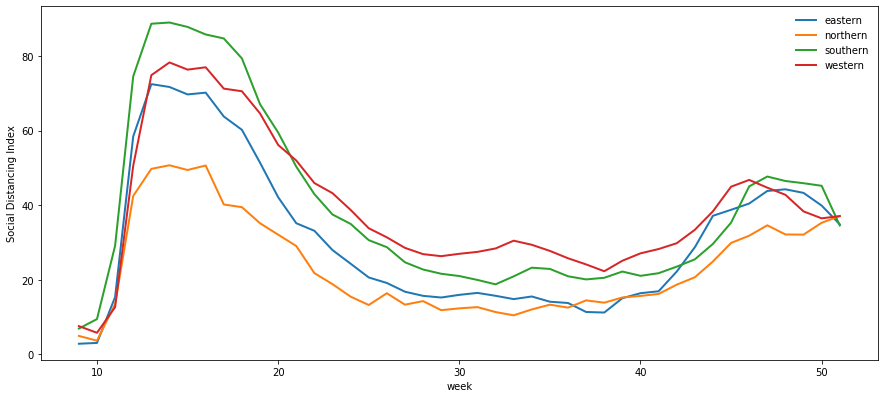

In [169]:
fig, ax = plt.subplots(1, figsize=(15,6.5))
ax.tick_params(axis='x', which='minor', width=0.0)

state_subset = ['western','eastern', 'southern', 'northern']
data.loc[data['eu_region'].isin(state_subset)].groupby(['week', 'eu_region'])['sdi'].mean().unstack().plot(ax=plt.gca(), linewidth=2)
ax.legend(frameon=False)
ax.set_ylabel(r'Social Distancing Index')

Text(0, 0.5, 'Infectivity')

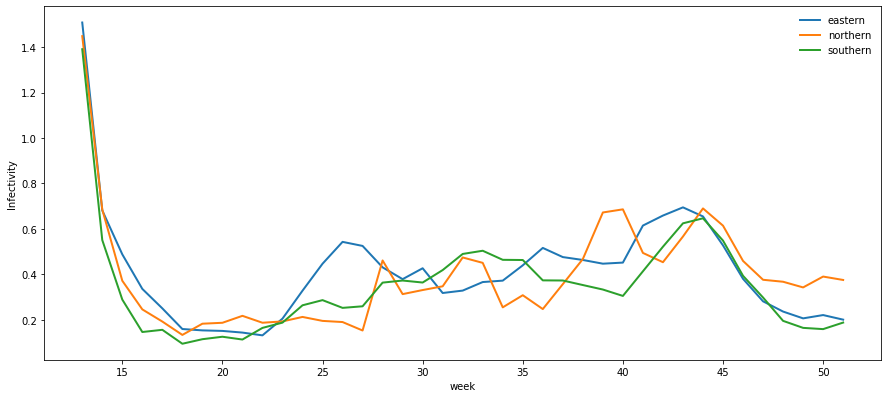

In [181]:
fig, ax = plt.subplots(1, figsize=(15,6.5))
ax.tick_params(axis='x', which='minor', width=0.0)

state_subset = ['southern','eastern', 'northern']
data.loc[data['eu_region'].isin(state_subset)].groupby(['week', 'eu_region'])['infectivity'].mean().unstack().plot(ax=plt.gca(), linewidth=2)
ax.legend(frameon=False)
ax.set_ylabel(r'Infectivity')

In [56]:
data

,country,week,ContainmentHealthIndex,population,case_weekly_count,case_rate_14_day,case_cumulative_count,death_weekly_count,death_rate_14_day,death_cumulative_count,...,sdi_lag_12,change_sdi_lag_12,sdi_lag_13,change_sdi_lag_13,sdi_lag_14,change_sdi_lag_14,ContainmentChange,14DayRollingContainmentChange,max_containment,high_containment
0,Austria,9,14.100000,8858775.0,14.0,0.158035,14.0,0.0,0.000000,0.0,...,41.013942,39.291127,38.203178,36.480363,34.470044,32.747230,NaN,27.472857,78.210000,True
1,Austria,10,15.748571,8858775.0,88.0,1.151401,102.0,0.0,0.000000,0.0,...,38.203178,33.893526,34.470044,30.160393,32.976048,28.666396,1.648571,27.472857,78.210000,True
2,Austria,11,43.221429,8858775.0,758.0,9.549853,860.0,1.0,0.112882,1.0,...,34.470044,18.598016,32.976048,17.104019,28.598411,12.726383,27.472857,27.472857,78.210000,True
3,Austria,12,63.551429,8858775.0,2771.0,39.836208,3631.0,15.0,1.806119,16.0,...,32.976048,-38.176151,28.598411,-42.553788,24.929190,-46.223009,20.330000,27.472857,78.210000,True
4,Austria,13,66.480000,8858775.0,5182.0,89.775392,8813.0,70.0,9.595006,86.0,...,28.598411,-55.268797,24.929190,-58.938018,19.138729,-64.728479,2.928571,27.472857,78.210000,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
941,United Kingdom,47,60.991429,66647112.0,142727.0,480.188849,1512045.0,2817.0,85.630117,54751.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.371429,7.505714,69.542857,False
942,United Kingdom,48,61.540000,66647112.0,105282.0,372.122651,1617327.0,3494.0,94.692775,58245.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.548571,7.505714,69.542857,False
943,United Kingdom,49,58.717143,66647112.0,105915.0,316.888450,1723242.0,3000.0,97.438581,61245.0,...,NaN,NaN,NaN,NaN,NaN,NaN,-2.822857,7.505714,69.542857,False
944,United Kingdom,50,65.330000,66647112.0,126161.0,348.216139,1849403.0,2925.0,88.901076,64170.0,...,NaN,NaN,NaN,NaN,NaN,NaN,6.612857,7.505714,69.542857,False


In [26]:
## Create changes in Social Distancing Index around containment changes
lag_low = -5
lag_high = 15
change_vars = []

data = data.reset_index()

for t in range(lag_low, lag_high):
    data['sdi_lag_' + str(t)] = data.groupby('country')['sdi'].shift(-t)
    data['change_sdi_lag_' + str(t)] = data['sdi_lag_' + str(t)] - data['sdi']
    change_vars += ['change_sdi_lag_' + str(t)]


data['ContainmentChange'] = data.groupby('country')['ContainmentHealthIndex'].diff()
data['14DayRollingContainmentChange'] = data.groupby('country')['ContainmentChange'].apply(lambda x: x.rolling(14, center=True, min_periods=1).max())
data['max_containment'] = data.groupby('country')['ContainmentHealthIndex'].transform(max)
median_max_containment = data['max_containment'].median()
data['high_containment'] = data['max_containment'] > median_max_containment

id_keep = ['country', 'week', 'ContainmentHealthIndex', 'ContainmentChange', '14DayRollingContainmentChange', 'high_containment']
data_event = data[id_keep + change_vars]
data_event_long = pd.melt(data_event, id_vars=id_keep, value_name='lagged_shadow_index')
data_event_long['lag'] = data_event_long['variable'].str.slice(start=len('change_sdi_lag_')).astype(int)

data_event_long['policy_incr_in_window'] = (data_event_long['14DayRollingContainmentChange'] > 5).astype(int)
unchanged_mean = data_event_long.groupby(['week', 'lag', 'policy_incr_in_window'])['lagged_shadow_index'].mean().unstack()[0].rename('avg_fixedpolicy_index_change')
if 'avg_fixedpolicy_index_change' not in data_event_long.columns:
    data_event_long = data_event_long.merge(unchanged_mean, on=['week', 'lag'], indicator='_m')

data_event_long['shadow_diff_v_mean'] = data_event_long['lagged_shadow_index'] - data_event_long['avg_fixedpolicy_index_change']



In [44]:
data_event_long

,country,week,ContainmentHealthIndex,ContainmentChange,14DayRollingContainmentChange,high_containment,variable,lagged_shadow_index,lag,policy_incr_in_window,avg_fixedpolicy_index_change,_m,Difference_in_SDI,perc_change_containment,lagged_shadow_index_elasticity
0,Austria,9,14.100000,NaN,27.472857,True,change_sdi_lag_-5,NaN,-5,1,NaN,both,NaN,NaN,NaN
1,Belgium,9,16.481429,NaN,27.377143,False,change_sdi_lag_-5,NaN,-5,1,NaN,both,NaN,NaN,NaN
2,Bulgaria,9,9.620000,NaN,18.775714,False,change_sdi_lag_-5,NaN,-5,1,NaN,both,NaN,NaN,NaN
3,Denmark,9,10.807143,NaN,24.908571,False,change_sdi_lag_-5,NaN,-5,1,NaN,both,NaN,NaN,NaN
4,France,9,29.621429,NaN,21.522857,True,change_sdi_lag_-5,NaN,-5,1,NaN,both,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18915,Slovakia,51,64.282857,-2.745714,1.922857,True,change_sdi_lag_14,NaN,14,0,NaN,both,NaN,-0.042713,NaN
18916,Slovenia,51,64.100000,0.000000,1.828571,True,change_sdi_lag_14,NaN,14,0,NaN,both,NaN,0.000000,NaN
18917,Spain,51,66.030000,0.000000,4.398571,False,change_sdi_lag_14,NaN,14,0,NaN,both,NaN,0.000000,NaN
18918,Sweden,51,57.050000,1.371429,3.848571,False,change_sdi_lag_14,NaN,14,0,NaN,both,NaN,0.024039,NaN


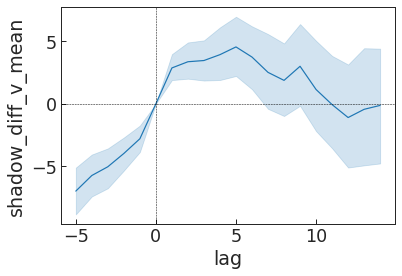

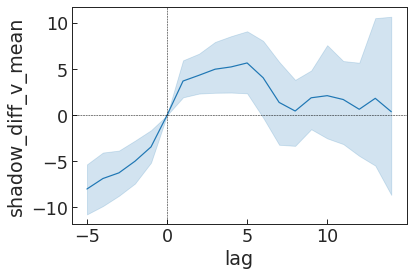

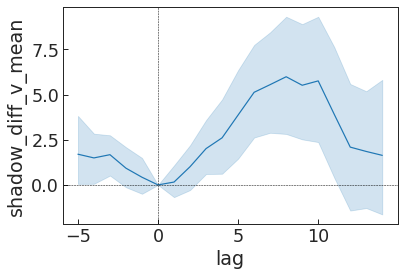

In [27]:
data_event_long['perc_change_containment'] = data_event_long['ContainmentChange'] / data_event_long['ContainmentHealthIndex']
data_event_long['lagged_shadow_index_elasticity'] = data_event_long['lagged_shadow_index'] / data_event_long['perc_change_containment'].apply(abs)

containment_dates = data_event_long.loc[data_event_long['perc_change_containment'] >= 0.05]
plt.figure()
sns.lineplot(data=containment_dates, x='lag', y='shadow_diff_v_mean')
plt.axvline(0, ls='--', color='black', linewidth=0.5)
plt.axhline(0, ls='--', color='black', linewidth=0.5)

containment_dates = data_event_long.loc[(data_event_long['perc_change_containment'] >= 0.1) & (data_event_long['week'] > 15)]
plt.figure()
sns.lineplot(data=containment_dates, x='lag', y='shadow_diff_v_mean')
plt.axvline(0, ls='--', color='black', linewidth=0.5)
plt.axhline(0, ls='--', color='black', linewidth=0.5)

containment_dates = data_event_long.loc[(data_event_long['perc_change_containment'] <= -0.05) & (data_event_long['week'] > 25)]
plt.figure()
sns.lineplot(data=containment_dates, x='lag', y='shadow_diff_v_mean')
plt.axvline(0, ls='--', color='black', linewidth=0.5)
plt.axhline(0, ls='--', color='black', linewidth=0.5)




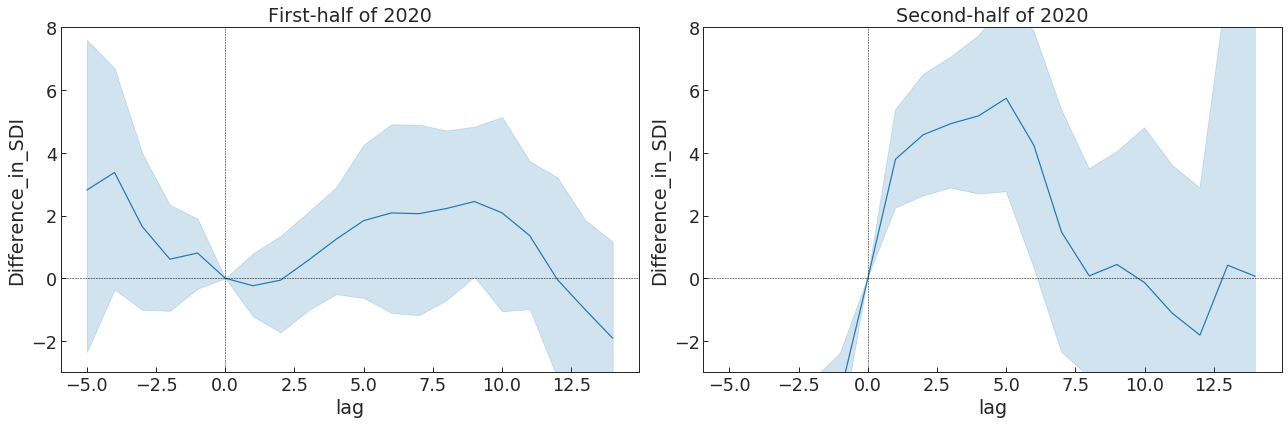

In [64]:
#[RESULTS TO USE]


data_event_long['perc_change_containment'] = data_event_long['ContainmentChange'] / data_event_long['ContainmentHealthIndex']
data_event_long['lagged_shadow_index_elasticity'] = data_event_long['lagged_shadow_index'] / data_event_long['perc_change_containment'].apply(abs)
data_event_long=data_event_long.rename(columns = {"shadow_diff_v_mean": "Difference_in_SDI"})
data_event_long["Difference_in_SDI"]

fig,axs = plt.subplots(1,2, figsize=(18,6))

containment_dates = data_event_long.loc[(data_event_long['perc_change_containment'] >= 0.0767) & (data_event_long['week'] < 30)]
sns.lineplot(data=containment_dates, x='lag', y='Difference_in_SDI', ax=axs[0])
axs[0].set_title('First-half of 2020')

containment_dates = data_event_long.loc[(data_event_long['perc_change_containment'] >= 0.0767) & (data_event_long['week'] > 29)]
sns.lineplot(data=containment_dates, x='lag', y='Difference_in_SDI', ax=axs[1])
axs[1].set_title('Second-half of 2020')

#containment_dates = data_event_long.loc[(data_event_long['perc_change_containment'] >= 0.05) & (data_event_long['week'] > 27)]
#sns.lineplot(data=containment_dates, x='lag', y='Difference_in_SDI', ax=axs[2])
#axs[2].set_title('Winter 2020')

for ax in axs:
  ax.axvline(0, ls='--', color='black', linewidth=0.5)
  ax.axhline(0, ls='--', color='black', linewidth=0.5)
  ax.set_ylim(-3,8)

plt.tight_layout()




In [63]:
data_event_long['perc_change_containment'] = data_event_long['ContainmentChange'] / data_event_long['ContainmentHealthIndex']
data_event_long['perc_change_containment'].quantile(0.85)



0.07667286245353169

In [51]:
data_event_long['perc_change_containment']


0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
           ...   
18915   -0.042713
18916    0.000000
18917    0.000000
18918    0.024039
18919    0.060579
Name: perc_change_containment, Length: 18920, dtype: float64